In [1]:
import os
os.environ["JAX_CACHE_DIR"] = "/cluster/scratch/mpundir/jax-cache"

import jax
jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
jax.config.update("jax_platforms", "cpu")

from femsolver.quadrature import get_element, Element
from femsolver.operator import Operator
from femsolver.jax_utils import auto_vmap 
import jax.numpy as jnp
import equinox as eqx

import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

In [2]:
# --- Mesh generation ---
def generate_unit_square_mesh_tri(nx, ny):
    x = jnp.linspace(0, 1, nx + 1)
    y = jnp.linspace(0, 1, ny + 1)
    xv, yv = jnp.meshgrid(x, y, indexing="ij")
    coords = jnp.stack([xv.ravel(), yv.ravel()], axis=-1)

    def node_id(i, j):
        return i * (ny + 1) + j

    elements = []
    for i in range(nx):
        for j in range(ny):
            n0 = node_id(i, j)
            n1 = node_id(i + 1, j)
            n2 = node_id(i, j + 1)
            n3 = node_id(i + 1, j + 1)
            elements.append([n0, n1, n3])
            elements.append([n0, n3, n2])
    return coords, jnp.array(elements)

We define a function to compute the linear elastic energy density based on the displacement gradients $\nabla u$.

$$
\Psi(x) =  \sigma(x) : \epsilon(x) 
$$

where $\sigma$ is the stress tensor and $\epsilon$ is the strain tensor.

$$
\sigma = \lambda \text{tr}(\epsilon) I + 2\mu \epsilon
$$

and 

$$
\epsilon = \frac{1}{2} (\nabla u + \nabla u^T)
$$


To ease the handling of the material paramters and later on ease the integration of the material parameters for computing energy density, we define a class `Material` that can be used to define the material parameters.

In [3]:
class Material(eqx.Module):
    mu: eqx.AbstractVar[float] 
    lmbda: eqx.AbstractVar[float]

In [4]:
# --- Material model (linear elasticity: plane strain) ---
@auto_vmap(grad_u=2)
def compute_strain(grad_u):
    return 0.5 * (grad_u + grad_u.T)

@auto_vmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps, mu, lmbda):
    I = jnp.eye(2)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I

@auto_vmap(grad_u=2, mu=0, lmbda=0)
def linear_elasticity_energy(grad_u, mu, lmbda):
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.sum(sigma * eps)


The femsolver provides a generic class `Operator` that can be used to solve FEM problems. This operator is the core of the library as it provide functions that can automatically integrate the energy density function defined above over the range of elements.

Below, we define a class `ElasticityOperator` that inherits from `Operator` and `Material`.

```python
class ElasticityOperator(Operator, Material):
    element: Element
    mu: float
    lmbda: float
```


In [5]:
class ElasticityOperator(Operator, Material):
    element: Element
    mu: float
    lmbda: float

    @auto_vmap(xi=1, wi=1, nodal_values=None, nodes=None)
    def integrand(self, xi, wi, nodal_values, nodes):
        u_quad, u_grad, detJ = self.element.get_local_values(
            xi, nodal_values, nodes
        )
        value = linear_elasticity_energy(u_grad, self.mu, self.lmbda)
        return wi * value * detJ

In [6]:
tri3 = get_element("tri3")
fem = ElasticityOperator(element=tri3, mu=1.0, lmbda=1.0)

In the above definition of the `Operator` class, we have used the `tri3` element.

One can simply replace this element with any other element. Just look at the `tri3` element in `femsolver/quadrature.py` to see how to define your own.

For more complex problems, one can define their own implementation of the `Operator` class. One just have to inherit from the `Operator` class and override the functions that are needed.

For example, if we want to solve a problem with a history dependent material model, we can define a new class that inherits from the `Operator` class and overrides the integration functions.

```python
class HistoryDependentOperator(Operator):
    element: Element
    @auto_vmap(xi=1, wi=1, nodal_values=None, nodes=None, history_variables=1)
    def integrate(self, xi, wi, nodal_values, nodes, history_variables):
        u_quad, u_grad, detJ = self.element.get_local_values(
            xi, nodal_values, nodes
        )
        value = self.integrand(u_grad, history_variables)
        return wi * value * detJ
```

For full implementation of such complex examples, please refere to the `examples/` directory.

Now we prepare the mesh and the boundary conditions and solve the linear elasticity problem.

In [7]:
# --- Mesh ---
coords, elements = generate_unit_square_mesh_tri(10, 10)
n_nodes = coords.shape[0]
n_dofs_per_node = 2
n_dofs = n_dofs_per_node * n_nodes
u = jnp.zeros(n_dofs)


# --- Total energy ---
def total_energy(u_flat, coords, elements, fem):
    u = u_flat.reshape(-1, n_dofs_per_node)
    u_cell = u[elements]
    x_cell = coords[elements]
    return jnp.sum(fem.integrate(u_cell, x_cell))


# creating functions to compute the gradient and 
# Hessian of the total energy using jax
grad_E = jax.grad(total_energy)
hess_E = jax.jacfwd(jax.grad(total_energy))

# compute the hessian which is the stiffness matrix 
# and the gradient which is the internal force vector 
K = hess_E(u, coords, elements, fem)
f_int = grad_E(u, coords, elements, fem)

# --- Apply Dirichlet BCs ---
left_nodes = jnp.where(jnp.isclose(coords[:, 0], 0.0))[0]
right_nodes = jnp.where(jnp.isclose(coords[:, 0], 1.0))[0]
fixed_dofs = jnp.concatenate(
    [
        2 * left_nodes,
        2 * left_nodes + 1,
        2 * right_nodes,
    ]
)
prescribed_values = jnp.zeros(n_dofs).at[2 * right_nodes].set(0.3)
free_dofs = jnp.setdiff1d(jnp.arange(n_dofs), fixed_dofs)

# --- Solve for the displacement ---
f_ext = -f_int - K @ prescribed_values
f_reduced = f_ext[free_dofs]
K_reduced = K[jnp.ix_(free_dofs, free_dofs)]
u_free = jnp.linalg.solve(K_reduced, f_reduced)
u_full = prescribed_values.at[free_dofs].set(u_free)

Now we prepare some functions to compute the stress and to plot the deformed shape with the von-mises stress.

In [8]:
@auto_vmap(stress=2)
def von_mises_stress(stress):
    s_xx, s_yy = stress[0, 0], stress[1, 1]
    s_xy = stress[0, 1]
    return jnp.sqrt(s_xx**2 - s_xx * s_yy + s_yy**2 + 3 * s_xy**2)


In [9]:
grad_us = fem.gradient(u_full.reshape(-1, n_dofs_per_node)[elements], coords[elements])
strains = compute_strain(grad_us)
stresses = compute_stress(strains, fem.mu, fem.lmbda)
stress_vm = von_mises_stress(stresses)

In [10]:
# --- Visualization ---
from femsolver.plotting import STYLE_PATH
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_displacement_and_stress(coords, u, elements, stress, scale=1.0):
    displaced = coords + scale * u
    tri_elements = elements
    
    plt.style.use(STYLE_PATH)
    fig =plt.figure(figsize=(5, 4))
    ax = plt.axes()
    cb =ax.tripcolor(
        displaced[:, 0],
        displaced[:, 1],
        tri_elements,
        facecolors=stress,
        shading="flat",
        cmap=cmc.managua_r,
        edgecolors="black",
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect("equal")
    ax.set_title("Von Mises Stress on Deformed Mesh")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(cb, cax=cax)
    plt.show()



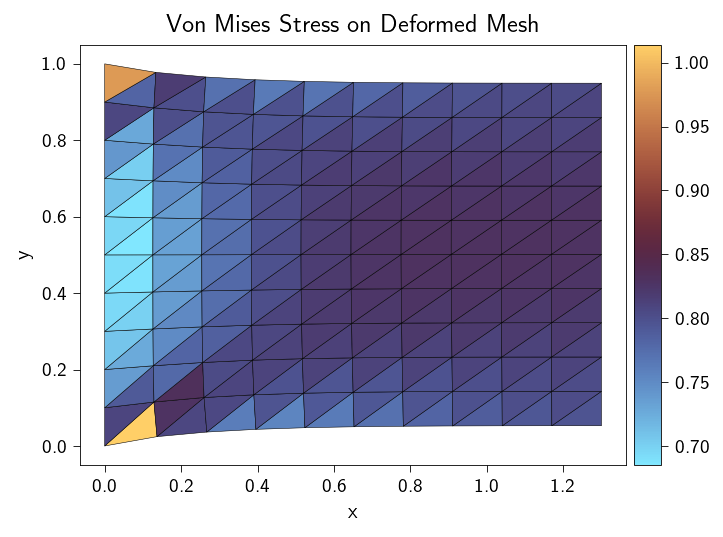

In [11]:
# --- Compute the stress ---    
u = u_full.reshape(-1, n_dofs_per_node)


# --- Plot the displacement and stress ---
plot_displacement_and_stress(coords, u, elements, stress_vm.flatten())